# Stellargraph example: Fully directed GraphSAGE on a directed CORA citation network

This example shows the application of *directed* GraphSAGE to a *directed* graph, where the in-node and out-node neighbourhoods are separately sampled and have different weights.

Import NetworkX and stellar:

In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import DirectedGraphSAGENodeGenerator
from stellargraph.layer import DirectedGraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML

### Loading the CORA network

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
dataset.download()

Load the graph from edgelist (in `cited-paper` <- `citing-paper` order)

In [3]:
edgelist = pd.read_csv(
    os.path.join(dataset.data_directory, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

Load the features and subject for the nodes

In [4]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names = feature_names + ["subject"]
node_data = pd.read_csv(
    os.path.join(dataset.data_directory, "cora.content"),
    sep="\t",
    header=None,
    names=column_names,
)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [5]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this

In [6]:
train_data, test_data = model_selection.train_test_split(
    node_data, train_size=0.1, test_size=None, stratify=node_data["subject"]
)

Note using stratified sampling gives the following counts:

In [7]:
from collections import Counter

Counter(train_data["subject"])

Counter({'Reinforcement_Learning': 22,
         'Theory': 35,
         'Genetic_Algorithms': 42,
         'Neural_Networks': 81,
         'Probabilistic_Methods': 42,
         'Case_Based': 30,
         'Rule_Learning': 18})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [8]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict("records"))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict("records"))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [9]:
node_features = node_data[feature_names]

## Creating the GraphSAGE model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

Note that the NetworkX graph is *directed*, so we also treat it here as *directed*.

In [10]:
G = sg.StellarDiGraph(nodes={"paper": node_features}, edges={"cites": edgelist})

/Users/wil9dw/projects/stellargraph/stellargraph-4/stellargraph/core/graph.py:211: ExperimentalWarning: StellarGraph(nodes=..., edges=...) is experimental: it has not been fully validated. It may be difficult to use and may have major changes at any time.
  ExperimentalWarning,


In [11]:
print(G.info())

<class 'stellargraph.core.graph.StellarDiGraph'>: Directed multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]


To feed data from the graph to the Keras model we need a data generator that feeds data from the graph to the model. The generators are specialized to the model and the learning task so we choose the `DirectedGraphSAGENodeGenerator` as we are predicting node attributes with a `DirectedGraphSAGE` model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer (5 in-nodes and 5 out-nodes), and 4 in the second layer (2 in-nodes and 2 out-nodes).

In [12]:
batch_size = 50
in_samples = [5, 2]
out_samples = [5, 2]

A `DirectedGraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [13]:
generator = DirectedGraphSAGENodeGenerator(G, batch_size, in_samples, out_samples)

Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [14]:
train_gen = generator.flow(train_data.index, train_targets, shuffle=True)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer, which corresponds to 12 weights for each head node, 10 for each in-node and 10 for each out-node.
 * The `bias` and `dropout` are internal parameters of the model. 

In [15]:
graphsage_model = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=False, dropout=0.5,
)

Now we create a model to predict the 7 categories using Keras softmax layers.

In [16]:
x_inp, x_out = graphsage_model.build()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [17]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [18]:
test_gen = generator.flow(test_data.index, test_targets)

In [19]:
history = model.fit_generator(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20


6/6 - 3s - loss: 1.8764 - acc: 0.2741 - val_loss: 1.7446 - val_acc: 0.4102


Epoch 2/20


6/6 - 3s - loss: 1.6785 - acc: 0.4704 - val_loss: 1.6404 - val_acc: 0.4323


Epoch 3/20


6/6 - 3s - loss: 1.5724 - acc: 0.5296 - val_loss: 1.5463 - val_acc: 0.4758


Epoch 4/20


6/6 - 3s - loss: 1.4268 - acc: 0.6481 - val_loss: 1.4576 - val_acc: 0.5788


Epoch 5/20


6/6 - 3s - loss: 1.3418 - acc: 0.7222 - val_loss: 1.3766 - val_acc: 0.6378


Epoch 6/20


6/6 - 3s - loss: 1.2418 - acc: 0.7963 - val_loss: 1.3104 - val_acc: 0.6751


Epoch 7/20


6/6 - 3s - loss: 1.1335 - acc: 0.8667 - val_loss: 1.2358 - val_acc: 0.7149


Epoch 8/20


6/6 - 3s - loss: 1.0375 - acc: 0.8704 - val_loss: 1.1801 - val_acc: 0.7166


Epoch 9/20


6/6 - 3s - loss: 0.9571 - acc: 0.8889 - val_loss: 1.1203 - val_acc: 0.7400


Epoch 10/20


6/6 - 3s - loss: 0.8831 - acc: 0.9370 - val_loss: 1.0669 - val_acc: 0.7514


Epoch 11/20


6/6 - 3s - loss: 0.8134 - acc: 0.9222 - val_loss: 1.0308 - val_acc: 0.7457


Epoch 12/20


6/6 - 3s - loss: 0.7662 - acc: 0.9333 - val_loss: 0.9896 - val_acc: 0.7588


Epoch 13/20


6/6 - 3s - loss: 0.7099 - acc: 0.9370 - val_loss: 0.9530 - val_acc: 0.7670


Epoch 14/20


6/6 - 3s - loss: 0.6654 - acc: 0.9593 - val_loss: 0.9273 - val_acc: 0.7748


Epoch 15/20


6/6 - 3s - loss: 0.6267 - acc: 0.9519 - val_loss: 0.9048 - val_acc: 0.7707


Epoch 16/20


6/6 - 3s - loss: 0.5764 - acc: 0.9704 - val_loss: 0.8727 - val_acc: 0.7834


Epoch 17/20


6/6 - 3s - loss: 0.5264 - acc: 0.9667 - val_loss: 0.8581 - val_acc: 0.7789


Epoch 18/20


6/6 - 3s - loss: 0.5181 - acc: 0.9593 - val_loss: 0.8419 - val_acc: 0.7822


Epoch 19/20


6/6 - 3s - loss: 0.4683 - acc: 0.9778 - val_loss: 0.8280 - val_acc: 0.7810


Epoch 20/20


6/6 - 3s - loss: 0.4500 - acc: 0.9778 - val_loss: 0.8097 - val_acc: 0.7838


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()

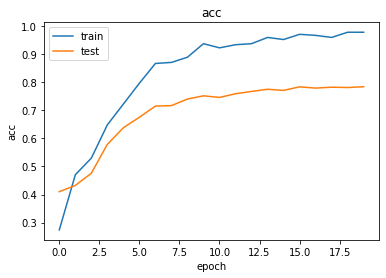

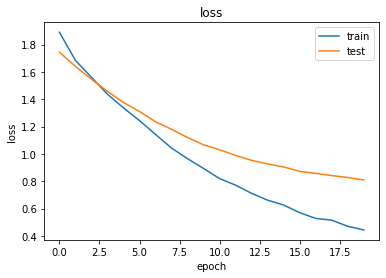

In [21]:
plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [22]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.8147
	acc: 0.7777


### Making predictions with the model

Now let's get the predictions themselves for all nodes using another node iterator:

In [23]:
all_nodes = node_data.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_mapper)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [24]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few:

In [25]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data["subject"]})
df.head(10)

,Predicted,True
31336,subject=Probabilistic_Methods,Neural_Networks
1061127,subject=Rule_Learning,Rule_Learning
1106406,subject=Reinforcement_Learning,Reinforcement_Learning
13195,subject=Reinforcement_Learning,Reinforcement_Learning
37879,subject=Probabilistic_Methods,Probabilistic_Methods
1126012,subject=Reinforcement_Learning,Probabilistic_Methods
1107140,subject=Reinforcement_Learning,Theory
1102850,subject=Theory,Neural_Networks
31349,subject=Theory,Neural_Networks
1106418,subject=Theory,Theory


## Node embeddings
Evaluate node embeddings as activations of the output of graphsage layer stack, and visualise them, coloring nodes by their subject label.

The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the `x_out` variable. Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [26]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [27]:
emb = embedding_model.predict_generator(all_mapper)
emb.shape

(2708, 32)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [29]:
X = emb
y = np.argmax(
    target_encoding.transform(node_data[["subject"]].to_dict("records")), axis=1
)

In [30]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_data.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_data.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

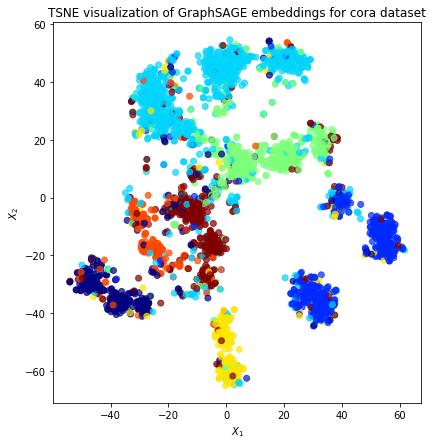

In [31]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()

Observe that each class of paper is separated into three general regions. This is due to the fact that the GraphSAGE features from the previous layer for the node itself, the aggregated in-neighbours, and the aggregated out-neighbours are currently concatenated in the form `[node, in_agg, out_agg]`.

There are four distinct types of directed neighbourhoods, namely: 
* Both in-neighbours and out-neighbours;
* Only in-neighbours – in this case `out_agg` will be zero; 
* Only out-neighbours – in this case `in_agg` will be zero;
* No in-neighbours or out-neighbours – in this case both `in_agg` and `out_agg` will be zero.

The fourth case, isolated nodes having no in-neighbours and no out-neighbours, does not occur for the CORA dataset (see the counts below) therefore the CORA dataset consists of the three types.

In [32]:
directed_neigh_type = [
    1 * (len(G.in_nodes(node)) > 0) + 2 * (len(G.out_nodes(node)) > 0)
    for node in node_data.index
]

print(f"{sum(nt==0 for nt in directed_neigh_type)} nodes have no in or out neighbours")
print(f"{sum(nt==1 for nt in directed_neigh_type)} nodes have in but not out neighbours")
print(f"{sum(nt==2 for nt in directed_neigh_type)} nodes have out but no in neighbours")
print(f"{sum(nt==3 for nt in directed_neigh_type)} nodes have in and out neighbours")

0 nodes have no in or out neighbours
486 nodes have in but not out neighbours
1143 nodes have out but no in neighbours
1079 nodes have in and out neighbours


**We visualize the clustering of these different directed neighbourhood types below:**

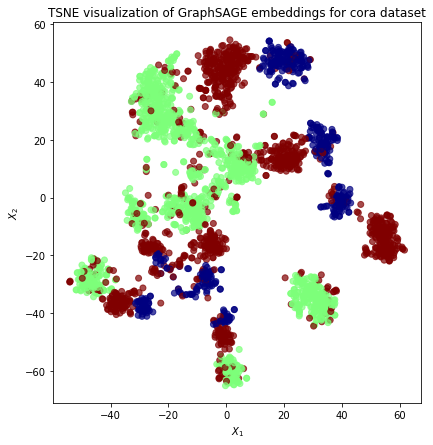

In [33]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0], emb_transformed[1], c=directed_neigh_type, cmap="jet", alpha=alpha
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)

plt.show()

We note that we can reduce the splitting effect of these different directed neighbourhood types by adding the aggregated in-neighbourhood and out-neighbourhood rather that concatenating them. This feature is planned to be implemented soon.